In [175]:
# Do we need to train the discriminator and generator?
# or just load the weights?
WGAN = False
TARGET_DIGIT = 8
BATCH_SIZE = 64
SEED_STD = 0.1

iters_lower, iters_upper = 120, 121


In [176]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from datetime import datetime
# Get the current date in YYYYMMDD format
current_date = datetime.now().strftime("%Y%m%d")

In [177]:
# Load MNIST data
(original_train_images, original_train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the entire dataset before splitting
normalized_images = original_train_images.astype('float32') / 255

# Define a split ratio for the dataset
split_ratio = 0.8  # e.g., 80% for training, 20% for validation / testing

# Calculate the number of images to include in the training set
num_train_images = int(len(normalized_images) * split_ratio)

# Split the images and labels into training and test sets
train_images = normalized_images[:num_train_images]
train_labels = original_train_labels[:num_train_images]
val_images = normalized_images[num_train_images:]
val_labels = original_train_labels[num_train_images:]

# Create a TensorFlow dataset for each digit in the training set
datasets = []
for digit in range(10):
    idx = train_labels == digit
    digit_images = train_images[idx]
    datasets.append(tf.data.Dataset.from_tensor_slices(digit_images).shuffle(1000).batch(60))

In [178]:
CHANNEL_N = 16 # Number of CA state channels
CELL_FIRE_RATE = 0.5

In [179]:
#@title CA model and utils
def to_greyscale(x):
    y = tf.clip_by_value(x[..., 0:1], 0.0, 1.0)
    return y

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(num_examples, channel_n=CHANNEL_N, seed_std=SEED_STD):
    h, w = 28,28
    seed = np.zeros([num_examples, h, w, channel_n], np.float32)
    for i in range(h//2 - 1, h//2 + 1):
        for j in range(w//2-1, w//2 + 1):
            seed[:, i, j, 0] = np.random.uniform(1, 1, size = num_examples)
            seed[:, i, j, 1:] = np.random.normal(0, seed_std, size = seed[:, i, j, 1:].shape)
#     seed = np.random.normal(0.5, 0.5, size = seed.shape)
    return seed

In [180]:
# Gaussian initialization
class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate

        self.perceive = tf.keras.Sequential([
            Conv2D(80, 3, activation=tf.nn.relu, padding="SAME"), # 80 filters, 3x3 kernel
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(80, 1, activation=tf.nn.relu),
            Conv2D(self.channel_n, 1, activation=tf.nn.tanh,
                kernel_initializer=tf.zeros_initializer),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * tf.cast(life_mask, tf.float32)

build_generator().dmodel.summary()

# TODO: TRY SIGMOID, square root loss 

Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_193 (Conv2D)         (1, 3, 3, 80)             6480      
                                                                 
 conv2d_194 (Conv2D)         (1, 3, 3, 16)             1296      
                                                                 
Total params: 7776 (30.38 KB)
Trainable params: 7776 (30.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


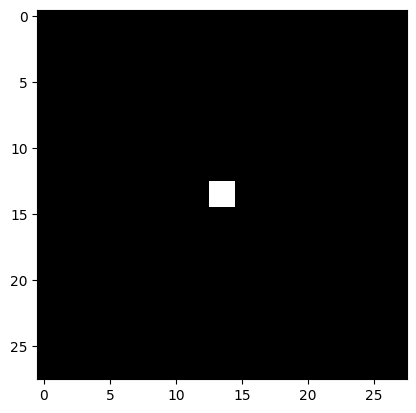

In [181]:
#@title Lets generate an image! (basic testing that the generator works, with animation)

generator = build_generator()

def animate_ca(generator, h=1, w=1):
    x = make_seed(1)

    for i in range(1):
        x = generator(x, training=False)
        plt.imshow(to_greyscale(x)[0, :, :, 0], cmap='gray')
        plt.show()
        # print(x[0,:,:,0].numpy().max())

    return x

x = animate_ca(generator)

In [182]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)

In [183]:
#@title Discriminator model and utils


def build_discriminator(input_shape=(28, 28, 1)):

    model = tf.keras.Sequential()

    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Flatten())
    model.add(Dense(1))  # No activation because the binary crossentropy loss function does the activation as well (using from logits)

    return model

discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.summary()


Model: "sequential_121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_198 (Conv2D)         (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu_66 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_199 (Conv2D)         (None, 7, 7, 32)          9248      
                                                                 
 leaky_re_lu_67 (LeakyReLU)  (None, 7, 7, 32)          0         
                                                                 
 flatten_33 (Flatten)        (None, 1568)              0         
                                                                 
 dense_33 (Dense)            (None, 1)                 1569      
                                                                 
Total params: 11137 (43.50 KB)
Trainable params: 111

In [184]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).

    x = test_input

    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    for i in tf.range(iter_n):
        x = model(x)

    predictions = x

    print("Iters: ", iter_n)
    plt.imshow(to_greyscale(predictions)[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    print(x.shape)

    return to_greyscale(predictions)[0, :, :, 0]


In [185]:
ca = build_generator()

In [186]:
def print_image_sample(images): 
    plt.figure(figsize=(10, 10))

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.show()

def noisify(images, noise_factor):

    noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = images + noise
    # Clip the values to be between 0 and 1
    noisy_images = tf.clip_by_value(noisy_images, clip_value_min=0.0, clip_value_max=1.0)
    return noisy_images


In [187]:
def add_noise_to_weights(model, noise_level=0):
    for layer in model.layers:
        weights = layer.get_weights()
        if weights:  # Check if the layer has weights
            noisy_weights = [w + noise_level * np.random.randn(*w.shape) for w in weights]
            layer.set_weights(noisy_weights)

In [188]:
#@title Wasserstein loss
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    y_true = tf.where(y_true == 1., tf.constant(-1., dtype=tf.float32), tf.constant(1., dtype=tf.float32))
    return tf.keras.backend.mean(y_true * y_pred)

In [189]:
discriminator = build_discriminator()

In [190]:
#@title Initialize Training
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # return -tf.reduce_mean(fake_output) # WGAN
    if WGAN: 
        wgan_loss = wasserstein_loss(tf.ones_like(fake_output), fake_output)
        l2_loss = tf.add_n(ca.dmodel.losses)
        return wgan_loss + l2_loss
    else: 
        cross_entropy_loss = cross_entropy(tf.ones_like(fake_output), fake_output) # Normal cross entropy
        return cross_entropy_loss

def discriminator_loss(real_output, fake_output):

    if WGAN:
        real_targets = tf.ones_like(real_output)
        
        real_loss = wasserstein_loss(real_targets, real_output)
        # return real_loss
        fake_loss = wasserstein_loss(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss * BATCH_SIZE + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss
    else: 
        real_targets = tf.ones_like(real_output)
        
        real_loss = cross_entropy(real_targets, real_output)
        # return real_loss
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

        total_loss = fake_loss + real_loss # TOCHECK do we want to scale the fake loss by the batch size?
        return total_loss

In [191]:
#@title New Training Loop {vertical-output: false}

import time
noise_factor = 0

@tf.function
def train_step(images, update_gen=True, update_disc=True, gen_batch_size = 1):
    iter_n = tf.random.uniform([], iters_lower, iters_upper, tf.int32)

    x = make_seed(gen_batch_size)  

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        for i in tf.range(iter_n):
            x = generator(x, training=True)  # Process the entire batch
        real_output = discriminator(noisify(images, noise_factor), training=True)
        fake_output = discriminator(noisify(to_greyscale(x)[:, :, :, 0], noise_factor), training=True)
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)

    if update_gen:
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_generator = [g/(tf.norm(g)+1e-8) for g in gradients_of_generator]
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    if update_disc:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Function to plot the current losses
def plot_losses(generator_losses, discriminator_losses, epoch):
    fig, axs = plt.subplots(2, figsize=(10, 10))

    axs[0].plot(generator_losses, label='Generator')
    axs[0].set_title(f'Generator Loss During Training - Epoch {epoch}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(discriminator_losses, label='Discriminator')
    axs[1].set_title(f'Discriminator Loss During Training - Epoch {epoch}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Training Loop
def train(dataset, epochs, gen_iters_per_disc_iter=1, add_noise_every=1, gen_batch_size=64):

    seed = make_seed(16)
    # Initialise lists for storing losses
    generator_losses = []
    discriminator_losses = []
    update_disc = tf.constant(False)
    clear_output(wait=True)
    generate_and_save_images(generator,
                            0,
                            seed)

    print("Getting warmed up...")

    for epoch in range(epochs):
        start = time.time()

        # Initialise the loss accumulators for the epoch
        epoch_gen_loss = 0.0
        epoch_disc_loss = 0.0
        
        for image_batch in dataset:
            
            if (epoch) % gen_iters_per_disc_iter == 0: 
                update_disc = tf.constant(True)
            else: 
                update_disc = tf.constant(False)
            gen_loss, disc_loss = train_step(image_batch, update_disc=update_disc, gen_batch_size=gen_batch_size)
            epoch_gen_loss += gen_loss
            epoch_disc_loss += disc_loss


        # Append the average losses to their respective lists
        generator_losses.append(epoch_gen_loss)
        discriminator_losses.append(epoch_disc_loss)

        # Produce images for the GIF as you go
        clear_output(wait=True)
        generate_and_save_images(generator,
                                epoch + 1,
                                seed)
        # Print the losses
        print(f"Epoch {epoch + 1}, Generator loss: {epoch_gen_loss:.4f}, Discriminator loss: {epoch_disc_loss:.4f}")
        print(f"Time for epoch {epoch + 1} is {time.time() - start} sec")
        plot_losses(generator_losses, discriminator_losses, epoch + 1)

    # Generate after the final epoch
    clear_output(wait=True)
    generate_and_save_images(generator,
                            epochs,
                            seed)
    plot_losses(generator_losses, discriminator_losses, epoch + 1)


In [192]:
EPOCHS = 1000

seed = make_seed(1)

generator = build_generator()
discriminator = build_discriminator()
generator.load_weights(f"ca_{TARGET_DIGIT}.h5")

g_loss_log = []
d_loss_log = []


# TODO consider weights and biases, tensorboard

In [193]:
noise_factor = 0
lr_gen = 2e-5
lr_disc = 2e-4

lr_sched_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_gen, lr_gen * 0.1])
lr_sched_disc = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [2000], [lr_disc, lr_disc * 0.1])

# Optimizers
generator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_gen)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(lr_sched_disc)

Iters:  tf.Tensor(120, shape=(), dtype=int32)


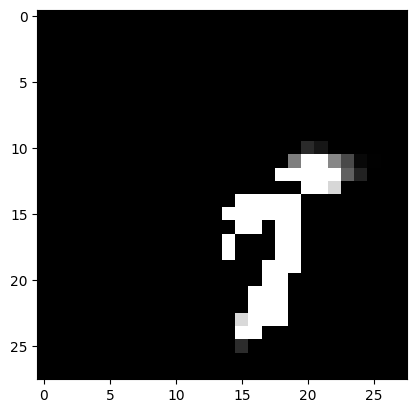

(16, 28, 28, 16)
Epoch 154, Generator loss: 287.6620, Discriminator loss: 6.6000
Time for epoch 154 is 494.0536859035492 sec


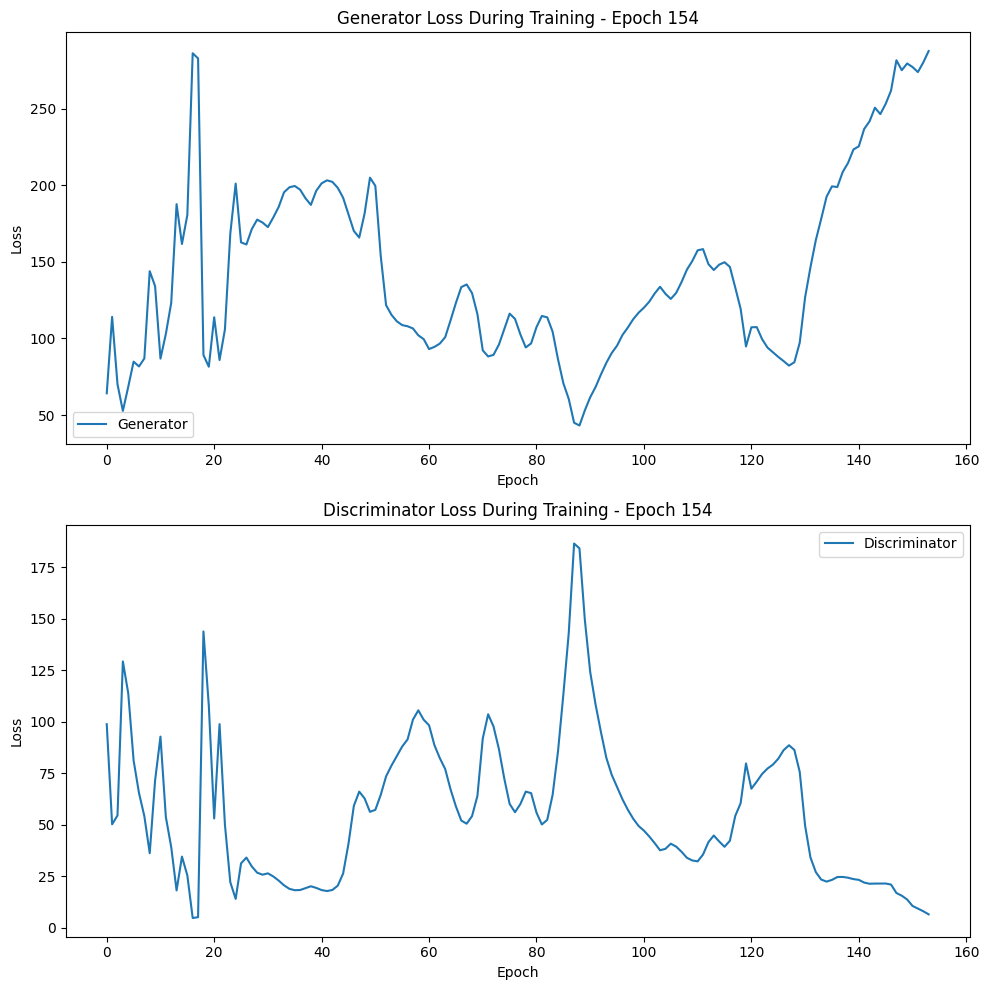

In [194]:
train(datasets[TARGET_DIGIT], EPOCHS, gen_iters_per_disc_iter=1)

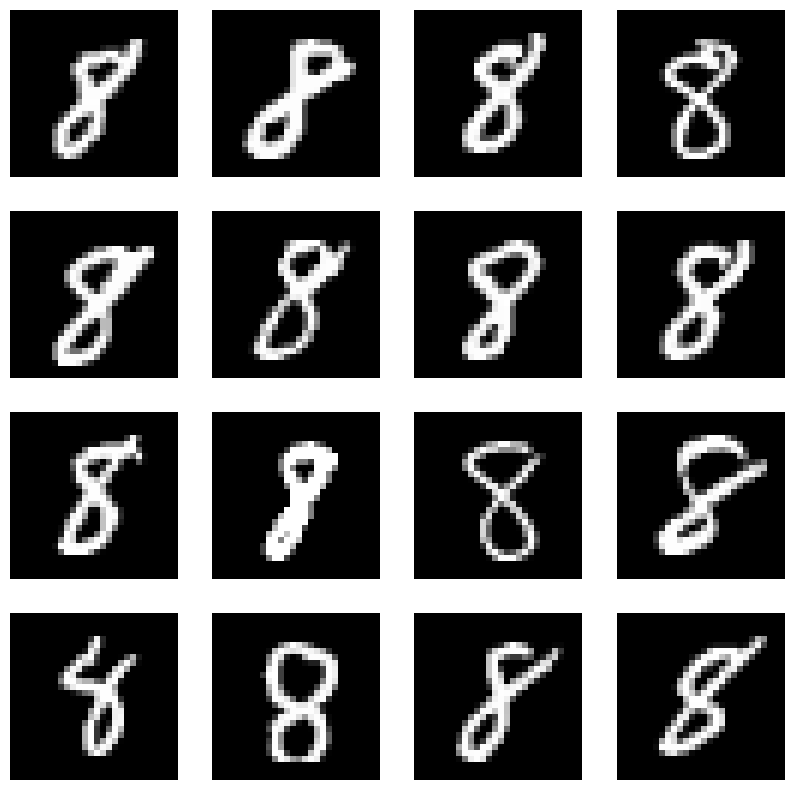

tf.Tensor(
[[0.97153336]
 [0.8682528 ]
 [0.96420485]
 [0.9520798 ]
 [0.9700844 ]
 [0.90510434]
 [0.9608536 ]
 [0.98449695]
 [0.92040277]
 [0.8205673 ]
 [0.8504406 ]
 [0.88278365]
 [0.41281202]
 [0.8887475 ]
 [0.90634936]
 [0.86298555]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_target[:16], 0))
print(tf.sigmoid(discriminator(images_of_target[:16])))

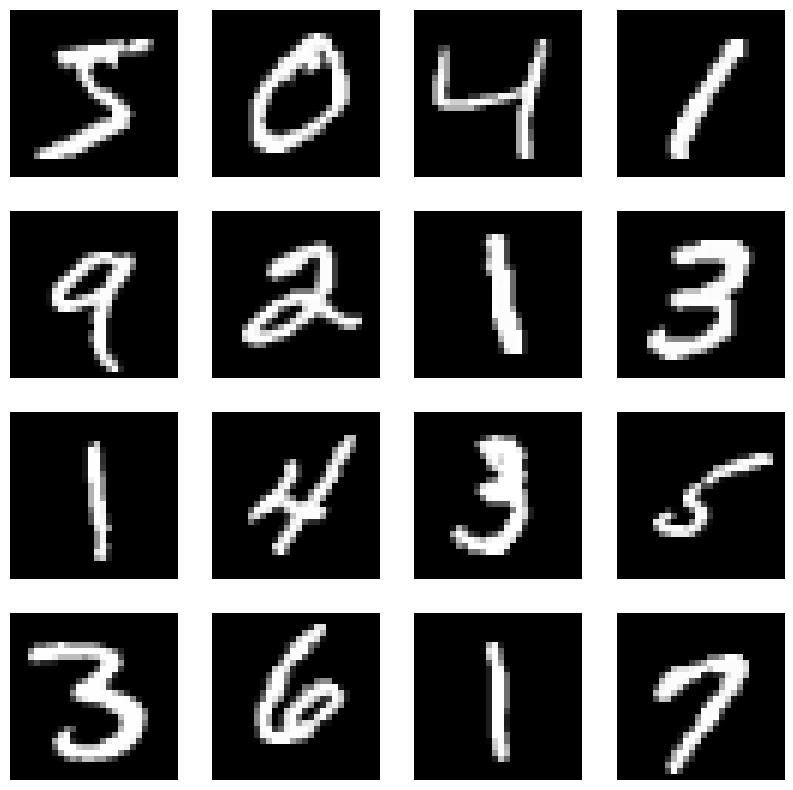

tf.Tensor(
[[0.05339272]
 [0.00971282]
 [0.00958136]
 [0.48083043]
 [0.34559682]
 [0.57327545]
 [0.19094017]
 [0.3342823 ]
 [0.2498089 ]
 [0.05236363]
 [0.21639939]
 [0.22484137]
 [0.09962499]
 [0.05332569]
 [0.40479288]
 [0.01612917]], shape=(16, 1), dtype=float32)


In [ ]:
print_image_sample(noisify(images_of_others[:16], 0))
print(tf.sigmoid(discriminator(images_of_others[:16])))

Iters:  tf.Tensor(70, shape=(), dtype=int32)


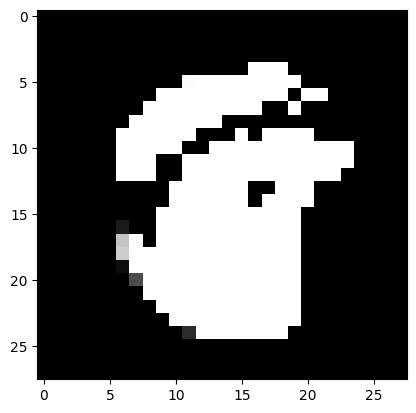

(1, 28, 28, 16)
tf.Tensor([[0.03977384]], shape=(1, 1), dtype=float32)


In [ ]:
image = noisify(generate_and_save_images(generator,0,seed)[None,...], 0)
# print_image_sample(image[..., None])

print(tf.sigmoid(discriminator(image)))

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
import imageio
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'